# Project | Natural Language Processing Challenge
### Fake news classifier

Environment

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import string

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

import nltk
nltk.download("wordnet")
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rache\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Load train and test data


In [2]:
# 1. Loading the training dataset
# The file is in TSV (Tab-Separated Values) format, hence sep="\t".
# Since the file does not have a header row, we manually define column names.
train_data_raw = pd.read_csv(
    "../data/training_data_lowercase.csv",
    sep="\t",
    header=None,
    names=["label", "text"]
)

# 2. Loading the unlabeled test dataset
# This dataset follows the same structure and will be used for final model evaluation.
test_data_raw = pd.read_csv(
    "../data/testing_data_lowercase_nolabels.csv",
    sep="\t",
    header=None,
    names=["label", "text"]
)

quick EDA

In [3]:
# preview
display(train_data_raw.head())

# shapes
print(
    f"Training data shape (rows, columns): {train_data_raw.shape}\n"
    f"Test data shape (rows, columns): {test_data_raw.shape}"
)


# fake news / real news balance
print("\nFake news / real news balance:")
print(train_data_raw["label"].value_counts(normalize=True))

# missing values
print("\nMissing values per column:")
print(train_data_raw.isnull().sum())

# empty text check
empty_texts = (train_data_raw["text"].str.strip() == "").sum()
print(f"\nNumber of empty text entries: {empty_texts}")


,label,text
0,0,donald trump sends out embarrassing new year‚s...
1,0,drunk bragging trump staffer started russian c...
2,0,sheriff david clarke becomes an internet joke ...
3,0,trump is so obsessed he even has obama‚s name ...
4,0,pope francis just called out donald trump duri...


Training data shape (rows, columns): (34152, 2)
Test data shape (rows, columns): (9984, 2)

Fake news / real news balance:
label
0    0.514523
1    0.485477
Name: proportion, dtype: float64

Missing values per column:
label    0
text     0
dtype: int64

Number of empty text entries: 0


Training - validation split

In [4]:
# 1. Feature and Target separation
# X contains the raw text data, while y contains the classification labels
X = train_data_raw["text"]
y = train_data_raw["label"]

# 2. Dataset Splitting
# test_size=0.2: Reserves 20% of the data for model evaluation
# random_state=42: Ensures the split is reproducible for consistent results
# stratify=y: Guarantees that the training and test sets have the same 
# proportion of 'Fake' and 'Real' news as the original dataset
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

Data cleaning

In [5]:
# Function to normalize text by removing special characters and extra whitespace
def clean_text(text):
    # Use Regular Expression (re) to keep only lowercase letters (a-z) and spaces
    text = re.sub(r"[^a-z\s]", " ", text)
    # Replace multiple consecutive spaces with a single space and trim edges
    text = re.sub(r"\s+", " ", text).strip()
    return text

# Apply the cleaning pipeline to both training and testing sets
X_train_clean = X_train.apply(clean_text)
X_test_clean  = X_test.apply(clean_text)

vectorization word2vec 
Word Embeddings vectorization

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

# 1. Feature Extraction using TF-IDF
# We use the cleaned text directly; TfidfVectorizer handles the tokenization internally.
# max_features=5000 limits the vocabulary to the top 5000 most important words to manage dimensionality.
tfidf = TfidfVectorizer(max_features=5000) 

# 2. Vectorize the text into a TF-IDF frequency matrix
# .fit_transform() learns the vocabulary and scales the training data.
# .transform() applies the same scaling to the test data to prevent data leakage.
X_train_tfidf = tfidf.fit_transform(X_train_clean)
X_test_tfidf = tfidf.transform(X_test_clean)

print("✅ TF-IDF Vectorization complete! (Essential for Naive Bayes performance)")

# 3. Model Initialization and Training
# Initializing the Multinomial Naive Bayes classifier and fitting it to the training data.
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)

# 4. Accuracy Evaluation
# Calculating performance metrics to assess how well the model generalizes to unseen data.
nb_train_acc = nb_model.score(X_train_tfidf, y_train)
nb_test_acc = nb_model.score(X_test_tfidf, y_test)

print(f"--- Naive Bayes (TF-IDF) ---")
print(f"Training Accuracy: {nb_train_acc * 100:.2f}%")
print(f"Testing Accuracy: {nb_test_acc * 100:.2f}%")

✅ TF-IDF Vectorization complete! (Essential for Naive Bayes performance)
--- Naive Bayes (TF-IDF) ---
Training Accuracy: 94.30%
Testing Accuracy: 93.31%


In [ ]:
!pip install xgboost


[notice] A new release of pip is available: 25.3 -> 26.0
[notice] To update, run: C:\Users\rache\AppData\Local\Programs\Python\Python313\python.exe -m pip install --upgrade pip


the final validation result for xgboost 

In [7]:
import pandas as pd
import numpy as np

# 1. Load the unlabeled validation dataset
# This file contains the data for which we need to predict labels (Fake vs Real).
final_val_df = pd.read_csv("../data/testing_data_lowercase_nolabels.csv", sep='\t', header=None)

# 2. Preprocessing & Feature Transformation (TF-IDF Specific)
print("Step 1: Cleaning validation text")
# We apply the same cleaning function to ensure consistency with training data.
val_texts_cleaned = final_val_df[1].apply(clean_text)

print("Step 2: Vectorizing with TF-IDF")
# Note: We use .transform() to project the validation data into the 
# pre-existing TF-IDF vocabulary space learned from the training set.
X_final_val_tfidf = tfidf.transform(val_texts_cleaned)

# 3. Model Inference (Naive Bayes)
print("Step 3: Running Naive Bayes prediction")
# Using the previously trained 'nb_model' to generate final predictions.
final_predictions = nb_model.predict(X_final_val_tfidf)

# 4. Final Formatting
# Replace the placeholder values in the first column with our model's predictions.
final_val_df[0] = final_predictions

# 5. Exporting the Results
# We save the results with a unique filename to avoid overwriting the XGBoost output.
# The format remains Tab-Separated (TSV) without headers or indices.
final_val_df.to_csv("validation_results_naive_bayes.csv", sep='\t', index=False, header=False)

print("The file 'validation_results_naive_bayes.csv' has been successfully generated!")

Step 1: Cleaning validation text
Step 2: Vectorizing with TF-IDF
Step 3: Running Naive Bayes prediction
The file 'validation_results_naive_bayes.csv' has been successfully generated!


In [8]:
# 1. Evaluate accuracy on the data the model was trained on (Training Set)
# This helps check if the model is overfitting.
nb_train_acc = nb_model.score(X_train_tfidf, y_train)

# 2. Evaluate accuracy on new, unseen data (Testing Set)
# This represents the model's true performance in a real-world scenario.
nb_test_acc = nb_model.score(X_test_tfidf, y_test)

print(f"--- Naive Bayes (TF-IDF) Results ---")
print(f"Training Accuracy: {nb_train_acc * 100:.2f}%")
print(f"Testing Accuracy: {nb_test_acc * 100:.2f}%")

--- Naive Bayes (TF-IDF) Results ---
Training Accuracy: 94.30%
Testing Accuracy: 93.31%


In [9]:
from sklearn.naive_bayes import MultinomialNB

# 1. Initialize the Multinomial Naive Bayes model
# This model is computationally efficient and runs almost instantly on CPU.
nb_model = MultinomialNB()

# 2. Model Training
# Training the model using the TF-IDF feature matrix.
nb_model.fit(X_train_tfidf, y_train)

# 3. Performance Evaluation
# Calculate accuracy on the test set to evaluate model generalization.
accuracy = nb_model.score(X_test_tfidf, y_test)

print(f"✅ Naive Bayes Training complete!")
print(f"🎯 Estimated Accuracy: {accuracy * 100:.2f}%")

✅ Naive Bayes Training complete!
🎯 Estimated Accuracy: 93.31%


In [10]:
from sklearn.naive_bayes import MultinomialNB

# 1. Initialize the Naive Bayes model 
# No need for GPU or torch here; this model is extremely lightweight and efficient on CPU!
nb_model = MultinomialNB()

# 2. Model Training
# We train the model using the TF-IDF feature matrix and the corresponding labels.
nb_model.fit(X_train_tfidf, y_train)

# 3. Evaluate Accuracy on the Test Set
# This measures how well the model generalizes to unseen data.
accuracy = nb_model.score(X_test_tfidf, y_test)

print(f" Naive Bayes Training complete!")
print(f" Estimated Accuracy: {accuracy * 100:.2f}%")

 Naive Bayes Training complete!
 Estimated Accuracy: 93.31%


In [11]:
# 1. Load the unlabeled challenge dataset
# This dataset contains the samples we need to classify for the final submission.
final_val_df = pd.read_csv("../data/testing_data_lowercase_nolabels.csv", sep='\t', header=None)

# 2. Text Preprocessing
# We apply the exact same cleaning function used during training to ensure pipeline consistency.
val_texts_cleaned = final_val_df[1].apply(clean_text)

# 3. TF-IDF Vectorization
# We use the '.transform()' method (not fit_transform) to project the new data 
# into the existing vocabulary space created during training.
X_final_val_tfidf = tfidf.transform(val_texts_cleaned)

# 4. Model Inference
# Generating predictions using the trained Naive Bayes classifier.
final_predictions = nb_model.predict(X_final_val_tfidf)

# 5. Label Replacement and Export
# Replace the placeholder labels (column 0) with our actual predictions.
final_val_df[0] = final_predictions
# Export to TSV format: No headers and no index as required by the challenge.
final_val_df.to_csv("validation_results_naive_bayes.csv", sep='\t', index=False, header=False)

print("Success! Your submission file 'validation_results_naive_bayes.csv' is ready.")

Success! Your submission file 'validation_results_naive_bayes.csv' is ready.


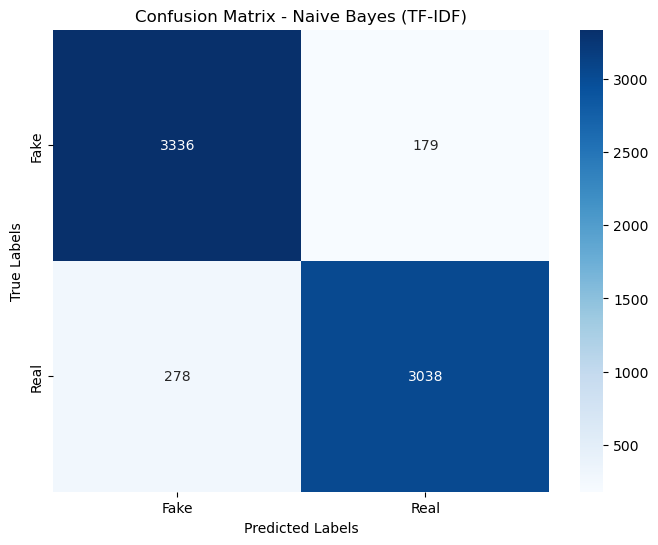


Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.95      0.94      3515
           1       0.94      0.92      0.93      3316

    accuracy                           0.93      6831
   macro avg       0.93      0.93      0.93      6831
weighted avg       0.93      0.93      0.93      6831



In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Generate predictions on the test set
y_pred_nb = nb_model.predict(X_test_tfidf)

# 2. Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_nb)

# 3. Plotting using Seaborn for a professional look
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Fake', 'Real'], 
            yticklabels=['Fake', 'Real'])

plt.title('Confusion Matrix - Naive Bayes (TF-IDF)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# 4. Detailed Classification Report
from sklearn.metrics import classification_report
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred_nb))